In [127]:
%load_ext autoreload
%autoreload 2
%cd ~/Research/Sriram/DeepSetRNN

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os
import string
import pickle
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import logging
import os
import importlib

from src import convert_dot_format
from src import experiment_utils

DATA_PATH='data/MIMIC3database'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/minh/Research/Sriram/DeepSetRNN


In [2]:
logging.info("starting logger")
_LOGGER = logging.getLogger('MIMIC_BOW_input_models')
_LOGGER.setLevel(logging.DEBUG)

# Preprocessing Data

In [3]:
top_n = 100 #should be the same as before
diagnoses_procedures_df = pd.read_csv('data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences_top_100_sorted.csv', index_col=0)

#converting sentences to a single column
diagnoses_procedures_df['DIAGNOSES_SENTENCES'] = diagnoses_procedures_df[['0_diagnoses', '1_diagnoses',
       '2_diagnoses', '3_diagnoses', '4_diagnoses', '5_diagnoses',
       '6_diagnoses', '7_diagnoses', '8_diagnoses', '9_diagnoses',
       '10_diagnoses', '11_diagnoses', '12_diagnoses', '13_diagnoses',
       '14_diagnoses', '15_diagnoses', '16_diagnoses', '17_diagnoses',
       '18_diagnoses', '19_diagnoses', '20_diagnoses', '21_diagnoses', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31']].values.tolist()

diagnoses_procedures_df['PROCEDURES_SENTENCES'] = diagnoses_procedures_df[
    ['0_procedures', '1_procedures', '2_procedures', '3_procedures',
       '4_procedures', '5_procedures', '6_procedures', '7_procedures',
       '8_procedures', '9_procedures', '10_procedures', '11_procedures',
       '12_procedures', '13_procedures', '14_procedures', '15_procedures',
       '16_procedures', '17_procedures', '18_procedures', '19_procedures',
       '20_procedures', '21_procedures']].values.tolist()

diagnoses_procedures_df.drop(labels=['0_diagnoses', '1_diagnoses',
       '2_diagnoses', '3_diagnoses', '4_diagnoses', '5_diagnoses',
       '6_diagnoses', '7_diagnoses', '8_diagnoses', '9_diagnoses',
       '10_diagnoses', '11_diagnoses', '12_diagnoses', '13_diagnoses',
       '14_diagnoses', '15_diagnoses', '16_diagnoses', '17_diagnoses',
       '18_diagnoses', '19_diagnoses', '20_diagnoses', '21_diagnoses', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31'], axis=1, inplace=True)

diagnoses_procedures_df.drop(labels=['0_procedures', '1_procedures', '2_procedures', '3_procedures',
       '4_procedures', '5_procedures', '6_procedures', '7_procedures',
       '8_procedures', '9_procedures', '10_procedures', '11_procedures',
       '12_procedures', '13_procedures', '14_procedures', '15_procedures',
       '16_procedures', '17_procedures', '18_procedures', '19_procedures',
       '20_procedures', '21_procedures'], axis=1, inplace=True)

diagnoses_procedures_df.to_csv("data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences_top_100_sorted_concat.csv")

In [40]:
from src.utils import get_onehot_vector

diagnoses_counts = diagnoses_procedures_df['ICD9_CODE_diagnoses'].value_counts()
procedures_counts = diagnoses_procedures_df['ICD9_CODE_procedures'].value_counts()

diagnoses_set = set(diagnoses_counts.keys()[:top_n])
procedures_set = set(procedures_counts.keys()[:top_n])

diagnoses_idx_map = {}
for i, code in enumerate(diagnoses_counts.keys()[:top_n]):
    diagnoses_idx_map[code] = i

procedures_idx_map = {}
for i, code in enumerate(procedures_counts.keys()[:top_n]):
    procedures_idx_map[code] = i
    
data = list(diagnoses_procedures_df.groupby(['SUBJECT_ID']))
data = [(subject_id, list(subject_data.groupby(['HADM_ID', 'ADMITTIME']))) for subject_id, subject_data in data]

all_inputs = []
all_outputs = []
for _, subject in data:
    input_series = []
    output_series = []
    for _, timestep in subject:
        timestep = timestep[timestep['ICD9_CODE_diagnoses'].isin(diagnoses_set)
                           | timestep['ICD9_CODE_procedures'].isin(procedures_set)]
        
        diagnoses_one_hot = get_onehot_vector(timestep['ICD9_CODE_diagnoses'], diagnoses_idx_map)
        procedures_one_hot = get_onehot_vector(timestep['ICD9_CODE_procedures'], procedures_idx_map)
            #skipping timesteps that are not relevant
        if len(timestep) > 0:
            input_series.append((np.append(diagnoses_one_hot, procedures_one_hot)))
            output_series.append(diagnoses_one_hot)
    if len(input_series) > 0 and len(output_series):
        all_inputs.append(torch.tensor(input_series))
        all_outputs.append(torch.tensor(output_series))
        
all_inputs = list(map(lambda x : x.type(torch.FloatTensor), all_inputs))
all_outputs = list(map(lambda x : x.type(torch.FloatTensor), all_outputs))

In [41]:
min_len = 3

inputs = list(filter(lambda x : len(x) >= min_len, all_inputs))
outputs = list(filter(lambda x: len(x) >= min_len, all_outputs))

n_seq = len(inputs)

split = int(n_seq*0.8)
train_inputs = inputs[:split]
train_outputs =  outputs[:split]

test_inputs = inputs[split:n_seq]
test_outputs = outputs[split:n_seq]

# Training Models

In [121]:
#global objects
training_loss_map = {}
model_map = {}

In [124]:
_MODEL_LOG_ROOT_PATH = 'logs/MIMIC3/bow'
_MODEL_ROOT_PATH = 'models/MIMIC3/bow'

In [125]:
def run_train_and_log_experiments(model_name, model, loss_fn, optimizer):
    experiment_utils.setup_model_logger(_LOGGER, model_name, _MODEL_LOG_ROOT_PATH)
    _LOGGER.info(model_name)

    #initial test loss
    test_losses = experiment_utils.evaluate_validation_loss(model, loss_fn, test_inputs, test_outputs)
    _LOGGER.info("Initial Validation Loss: {}".format(np.mean(test_losses)))

    #training model
    training_losses = experiment_utils.train_model(model, loss_fn, optimizer,
                                                  args.n_epoch, train_inputs, 
                                                   train_outputs, _LOGGER)

    #saving model
    torch.save(model, '{}/{}.pt'.format(_MODEL_ROOT_PATH, model_name))

    #final validation loss
    test_losses = experiment_utils.evaluate_validation_loss(model, loss_fn, test_inputs, test_outputs)
    _LOGGER.info("final validation Loss: {}".format(np.mean(test_losses)))

    #saving model in global map
    model_map[model_name] = model
    training_loss_map[model_name] = training_losses

In [67]:
######LSTM MODEL#####
from src.model.mimic_onehot import OneHotLSTMClassifier

LSTMArgs = namedtuple('BOW_LSTM', 
                      ['hidden_dim',
                       'n_epoch',
                       'lr',
                       'momentum',
                      'n_layers'])
args = LSTMArgs(
    hidden_dim=[1000,100],
    n_epoch = 10,
    lr = 0.1,
    n_layers=1,
    momentum = 0.9
)

model_name = str(args)

model = OneHotLSTMClassifier(
    input_dim=len(inputs[0][0]),
    hidden_dims=args.hidden_dim,
    n_layers=args.n_layers,
    n_class=top_n)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
run_train_and_log_experiments(model_name, model, loss_fn, optimizer)
# _LOGGER.handlers = [
#     h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
# model_name = "onehotLSTM_top_{}_{}hd_{}".format(top_n, args.hidden_dim, args.n_epoch)
# fh = logging.FileHandler('logs/MIMIC3/onehot/{}.log'.format(model_name))
# fh.setLevel(logging.DEBUG)
# _LOGGER.addHandler(fh)

# loss_fn = nn.BCEWithLogitsLoss()

# optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

# #initial test loss
# test_losses = []
# for sequence, target in zip(test_inputs, test_outputs):
#     logits = model(sequence.view(len(sequence), 1, -1))
#     loss = loss_fn(logits[:-1],target[1:])
#     test_losses.append(loss.data)
# _LOGGER.info("Initial Validation Loss: {}".format(np.mean(test_losses)))

# #training model
# training_losses = []
# for epoch in range(args.n_epoch):
#     curr_losses = []
#     for sequence, target in zip(train_inputs,
#                                 train_outputs):
#         model.zero_grad()
        
#         logits = model(sequence.view(len(sequence), 1, -1))
#         loss = loss_fn(logits[1:], target[1:])
#         curr_losses.append(loss.data)
#         loss.backward()
#         optimizer.step()
#     mean_loss = np.mean(curr_losses)
#     training_losses.append(mean_loss)
#     _LOGGER.info("epoch {}: {}".format(epoch, mean_loss))
    

# #final validation loss
# test_losses = []
# for sequence, target in zip(test_inputs, test_outputs):
#     model.hidden = model.init_hidden()
#     logits = model(sequence.view(len(sequence), 1, -1))
#     loss = loss_fn(logits[:-1],target[1:])
#     test_losses.append(loss.data)
# _LOGGER.info("final validation Loss: {}".format(np.mean(test_losses)))

# #saving model
# torch.save(model, 'models/MIMIC3/{}.pt'.format(model_name))
# model_map[model_name] = model
# training_loss_map[model_name] = training_losses

INFO:MIMIC_BOW_input_models:Initial Validation Loss: 0.691765546798706
INFO:MIMIC_BOW_input_models:epoch 0: 0.23655198514461517
INFO:MIMIC_BOW_input_models:epoch 1: 0.19299526512622833
INFO:MIMIC_BOW_input_models:epoch 2: 0.1640198677778244
INFO:MIMIC_BOW_input_models:epoch 3: 0.13627828657627106
INFO:MIMIC_BOW_input_models:epoch 4: 0.1121881827712059
INFO:MIMIC_BOW_input_models:epoch 5: 0.09256398677825928
INFO:MIMIC_BOW_input_models:epoch 6: 0.07502803206443787
INFO:MIMIC_BOW_input_models:epoch 7: 0.0597909651696682
INFO:MIMIC_BOW_input_models:epoch 8: 0.04646218940615654
INFO:MIMIC_BOW_input_models:epoch 9: 0.034851349890232086
INFO:MIMIC_BOW_input_models:final validation Loss: 0.4401245415210724


In [68]:
######FCN MODEL#####
from src.model.mimic_onehot import OneHotFullyConnectedClassifier

FCArgs = namedtuple('FCArgs', 
                      ['hidden_dim',
                       'n_epoch',
                       'lr',
                       'momentum'])
args = FCArgs(
    hidden_dim=[1000,100],
    n_epoch = 10,
    lr = 0.1,
    momentum = 0.9
)


_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
model_name = "onehotFCN_top_{}_{}hd_{}".format(top_n, args.hidden_dim, args.n_epoch)
fh = logging.FileHandler('logs/MIMIC3/onehot/{}.log'.format(model_name))
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

model = OneHotFullyConnectedClassifier(
    input_dim=len(inputs[0][0]),
    hidden_dims=args.hidden_dim,
    n_class=top_n)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

run_train_and_log_experiments(model_name, model, loss_fn, optimizer)


#initial test loss
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    logits = model(sequence.view(len(sequence), 1, -1))
    loss = loss_fn(logits[:-1],target[1:])
    test_losses.append(loss.data)
_LOGGER.info("Initial Validation Loss: {}".format(np.mean(test_losses)))

#training model
training_losses = []
for epoch in range(args.n_epoch):
    curr_losses = []
    for sequence, target in zip(train_inputs,
                                train_outputs):
        model.zero_grad()
        
        logits = model(sequence.view(len(sequence), 1, -1))
        loss = loss_fn(logits[1:], target[1:])
        curr_losses.append(loss.data)
        loss.backward()
        optimizer.step()
    mean_loss = np.mean(curr_losses)
    training_losses.append(mean_loss)
    _LOGGER.info("epoch {}: {}".format(epoch, mean_loss))
    

#final validation loss
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    logits = model(sequence.view(len(sequence), 1, -1))
    loss = loss_fn(logits[:-1],target[1:])
    test_losses.append(loss.data)
_LOGGER.info("final validation Loss: {}".format(np.mean(test_losses)))

#saving model
torch.save(model, 'models/MIMIC3/{}.pt'.format(model_name))
model_map[model_name] = model
training_loss_map[model_name] = training_losses

INFO:MIMIC_BOW_input_models:Initial Validation Loss: 0.6897575259208679
INFO:MIMIC_BOW_input_models:epoch 0: 0.1897343546152115
INFO:MIMIC_BOW_input_models:epoch 1: 0.08518476784229279
INFO:MIMIC_BOW_input_models:epoch 2: 0.03899113088846207
INFO:MIMIC_BOW_input_models:epoch 3: 0.018275849521160126
INFO:MIMIC_BOW_input_models:epoch 4: 0.009504181332886219
INFO:MIMIC_BOW_input_models:epoch 5: 0.005533972755074501
INFO:MIMIC_BOW_input_models:epoch 6: 0.0035512696485966444
INFO:MIMIC_BOW_input_models:epoch 7: 0.0024589081294834614
INFO:MIMIC_BOW_input_models:epoch 8: 0.0018160711042582989
INFO:MIMIC_BOW_input_models:epoch 9: 0.0014105952577665448
INFO:MIMIC_BOW_input_models:final validation Loss: 0.7672504186630249


In [129]:
######LogReg MODEL#####
from src.model.mimic_onehot import OneHotLogRegClassifier

LogRegArgs = namedtuple('LogRegArgs', 
                      ['n_epoch',
                       'lr',
                       'momentum'])
args = LogRegArgs(
    n_epoch = 10,
    lr = 0.1,
    momentum = 0.9
)

model_name = str(args)
model = OneHotLogRegClassifier(
    input_dim=len(inputs[0][0]),
    n_class=top_n)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
run_train_and_log_experiments(model_name, model, loss_fn, optimizer)

INFO:MIMIC_BOW_input_models:LogRegArgs(n_epoch=10, lr=0.1, momentum=0.9)
INFO:MIMIC_BOW_input_models:Initial Validation Loss: 0.6957917809486389
DEBUG:MIMIC_BOW_input_models:training model
INFO:MIMIC_BOW_input_models:epoch: 0, loss: 0.25062865018844604
INFO:MIMIC_BOW_input_models:epoch: 1, loss: 0.1392589509487152
INFO:MIMIC_BOW_input_models:epoch: 2, loss: 0.10380976647138596
INFO:MIMIC_BOW_input_models:epoch: 3, loss: 0.08206409215927124
INFO:MIMIC_BOW_input_models:epoch: 4, loss: 0.06722668558359146
INFO:MIMIC_BOW_input_models:epoch: 5, loss: 0.056505415588617325
INFO:MIMIC_BOW_input_models:epoch: 6, loss: 0.0484527051448822
INFO:MIMIC_BOW_input_models:epoch: 7, loss: 0.04222531616687775
INFO:MIMIC_BOW_input_models:epoch: 8, loss: 0.03729526326060295
INFO:MIMIC_BOW_input_models:epoch: 9, loss: 0.03331499546766281
INFO:MIMIC_BOW_input_models:final validation Loss: 0.27417877316474915


# Analysis

In [103]:
import os
log_path = 'logs/MIMIC3/onehot/onehot_models_analysis.log'
if os.path.exists(log_path):
    os.remove(log_path)

_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
fh = logging.FileHandler('logs/MIMIC3/onehot/onehot_models_analysis.log')
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

In [104]:
test_prediction_map = {}
test_logits_map = {}
test_output_map = {}
#preprocessing test outputs
sigmoid = nn.Sigmoid()
for model_name, model in model_map.items():
    all_logits = []
    all_outputs = []
    all_predictions = []
    for sequence, target in zip(test_inputs, test_outputs):    
    
        if 'LSTM' in model_name:
            model.hidden = model.init_hidden()

        logits = model(sequence.view(len(sequence), 1, -1))

        model_outputs = sigmoid(logits).detach().numpy()
        predictions = model_outputs > 0.5
        predictions = predictions.astype(np.float32)

        all_outputs.append(model_outputs)
        all_logits.append(logits.detach().numpy())
        all_predictions.append(predictions)
    test_prediction_map[model_name] = all_predictions
    test_logits_map[model_name] = all_logits
    test_output_map[model_name] = all_outputs

In [105]:
#precision@k
from src.utils import precision_at_k, bootstrap_CI
k_values = [1,2,3]
for k in k_values:
    _LOGGER.info("Precision@{}".format(k))
    for model_name in model_map:
            pk = precision_at_k(test_logits_map[model_name], test_outputs, k)
            _LOGGER.info("{} {}".format(model_name, pk))

INFO:MIMIC_BOW_input_models:onehotLSTM_top_100_[1000, 100]hd_10 0.6049469709396362
INFO:MIMIC_BOW_input_models:onehotFCN_top_100_[1000, 100]hd_10 0.569307267665863
INFO:MIMIC_BOW_input_models:onehotLogReg_top_100_hd_10 0.6522011160850525
INFO:MIMIC_BOW_input_models:onehotLSTM_top_100_[1000, 100]hd_10 0.5743560194969177
INFO:MIMIC_BOW_input_models:onehotFCN_top_100_[1000, 100]hd_10 0.5418902635574341
INFO:MIMIC_BOW_input_models:onehotLogReg_top_100_hd_10 0.5997685790061951
INFO:MIMIC_BOW_input_models:onehotLSTM_top_100_[1000, 100]hd_10 0.5346375703811646
INFO:MIMIC_BOW_input_models:onehotFCN_top_100_[1000, 100]hd_10 0.5139472484588623
INFO:MIMIC_BOW_input_models:onehotLogReg_top_100_hd_10 0.5510472655296326


In [107]:
#precision@k with confidence intervals
from src.utils import precision_at_k, bootstrap_CI
from sklearn.utils import resample

k_values = [1,2,3]
n_bootstrap = 1000

bootstrap_pk_map = {}
pk_CI_map = {}

for k in k_values:
    _LOGGER.info("Computing Precision@{}".format(k))
    for model_name in model_map:
        pk, CI = bootstrap_CI(precision_at_k, {'k':k}, 
                             (test_logits_map[model_name], test_outputs),
                              n_bootstrap)
        bootstrap_pk_map[model_name] = pk
        pk_CI_map[model_name] = CI
        _LOGGER.info("{} {}".format(model_name, CI))

INFO:MIMIC_BOW_input_models:Computing Precision@1
INFO:MIMIC_BOW_input_models:onehotLSTM_top_100_[1000, 100]hd_10 (0.6047551771652766, 0.6067540505874089)
INFO:MIMIC_BOW_input_models:onehotFCN_top_100_[1000, 100]hd_10 (0.568014509104873, 0.5701037579544531)
INFO:MIMIC_BOW_input_models:onehotLogReg_top_100_hd_10 (0.6509806402772951, 0.6531390658765746)
INFO:MIMIC_BOW_input_models:Computing Precision@2
INFO:MIMIC_BOW_input_models:onehotLSTM_top_100_[1000, 100]hd_10 (0.5735762845879869, 0.5751827228659315)
INFO:MIMIC_BOW_input_models:onehotFCN_top_100_[1000, 100]hd_10 (0.5410013103743153, 0.5426333045701427)
INFO:MIMIC_BOW_input_models:onehotLogReg_top_100_hd_10 (0.5985171102128846, 0.6002326704420227)
INFO:MIMIC_BOW_input_models:Computing Precision@3
INFO:MIMIC_BOW_input_models:onehotLSTM_top_100_[1000, 100]hd_10 (0.5336115220346971, 0.5349754234990554)
INFO:MIMIC_BOW_input_models:onehotFCN_top_100_[1000, 100]hd_10 (0.5131820379253879, 0.5146104158404813)
INFO:MIMIC_BOW_input_models:oneh

In [106]:
true_labels_flattened = torch.cat(list((map(lambda x : x.flatten(), test_outputs))))
for model_name in model_map:
    predictions = test_prediction_map[model_name]
    predictions_flattened = np.concatenate(list(map(lambda x : x.flatten(), predictions)))
    _LOGGER.info("{}\n{}".format(model_name,metrics.confusion_matrix(true_labels_flattened, predictions_flattened)))

INFO:MIMIC_BOW_input_models:onehotLSTM_top_100_[1000, 100]hd_10
[[154365    583]
 [  2450  10902]]
INFO:MIMIC_BOW_input_models:onehotFCN_top_100_[1000, 100]hd_10
[[154914     34]
 [   359  12993]]
INFO:MIMIC_BOW_input_models:onehotLogReg_top_100_hd_10
[[154948      0]
 [  1027  12325]]


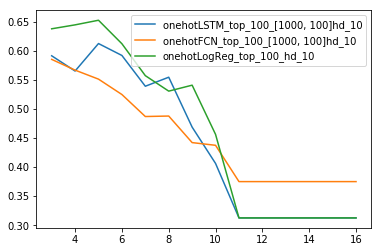

In [108]:
k = 1
pk_vs_len_map = {}

max_len = max(map(len, test_outputs))
for model_name in model_map:
    pks = []
    filtered_logits = test_logits_map[model_name]
    filtered_test_outputs = test_outputs
    
    for filter_len in range(min_len, max_len):
        indices = [i for (i,sequence) in enumerate(filtered_test_outputs) if len(sequence) > filter_len]
        
        filtered_logits = [filtered_logits[i] for i in indices]
        filtered_test_outputs = [filtered_test_outputs[i] for i in indices]
        #print(len(filtered_test_outputs))
        pks.append(precision_at_k(filtered_logits, filtered_test_outputs, k))
    pk_vs_len_map[model_name] = pks
    
max_len = max(map(len, test_outputs))

for model_name, pks in pk_vs_len_map.items():
    plt.plot(np.arange(3,max_len), pks, label=model_name)
plt.legend()